In [1]:
pip install torch torchvision facenet-pytorch opencv-python albumentations pandas

INFO: pip is looking at multiple versions of facenet-pytorch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [3]:
import json
import pandas as pd

json_file = '/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json'
df = pd.read_json(json_file)
df = df.T

df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [4]:
import json
import os

# 메타데이터 파일 경로 리스트
metadata_paths = [
    '/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json', 
    # '/content/gdrive/MyDrive/Colab Notebooks/2024_OSP_SW/train_videos/dfdc_train_part_1/metadata.json'
]

# 메타데이터 병합
metadata = {}
for path in metadata_paths:
    if os.path.exists(path):  # 파일 존재 여부 확인
        with open(path, "r") as f:
            data = json.load(f)
            metadata.update(data)  # 기존 metadata에 새 데이터를 병합
    else:
        print(f"Warning: Metadata file not found at {path}")

# 데이터 확인
print(f"Total metadata entries: {len(metadata)}")


Total metadata entries: 400


In [5]:
import os
import json
import random
import pandas as pd

# 데이터셋 경로 설정
folders = [
    '/kaggle/input/deepfake-detection-challenge/train_sample_videos'
]

# 메타데이터 파일 경로 설정
metadata_paths = ['/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json']

# 모든 메타데이터 로드
metadata_json = {}  # 초기화
for metadata_path in metadata_paths:
    with open(metadata_path, "r") as f:
        metadata_json.update(json.load(f))  # 여러 메타데이터 병합

# 모든 비디오 파일과 라벨 수집
all_videos = []
for folder in folders:
    for file_name in os.listdir(folder):
        if file_name.endswith(".mp4") and file_name in metadata_json:  # .mp4 확장자 및 메타데이터 확인
            label = metadata_json[file_name]["label"]  # 메타데이터에서 라벨 가져오기
            all_videos.append({
                "video_name": os.path.join(folder, file_name),  # 전체 경로 저장
                "label": 0 if label == "REAL" else 1  # 0: REAL, 1: FAKE
            })

# Pandas DataFrame 생성
metadata_df = pd.DataFrame(all_videos)

# REAL과 FAKE 비디오 분리
real_videos = metadata_df[metadata_df["label"] == 0]["video_name"].tolist()
fake_videos = metadata_df[metadata_df["label"] == 1]["video_name"].tolist()

# 테스트용 비디오 샘플링 (20%)
test_real = random.sample(real_videos, int(len(real_videos) * 0.2))
test_fake = random.sample(fake_videos, min(len(fake_videos), int(len(test_real) * 2)))  # REAL의 2배로 샘플링

# 테스트용 비디오 제거 후 나머지로 훈련 데이터셋 구성
train_real = list(set(real_videos) - set(test_real))
train_fake = list(set(fake_videos) - set(test_fake))
train_fake = random.sample(train_fake, min(len(train_fake), len(train_real) * 2))  # REAL의 2배

# 훈련 데이터프레임 생성
train_data = pd.DataFrame({
    "video_name": train_real + train_fake,
    "label": [0] * len(train_real) + [1] * len(train_fake)  # 0: REAL, 1: FAKE
})

# 테스트 데이터프레임 생성
test_data = pd.DataFrame({
    "video_name": test_real + test_fake,
    "label": [0] * len(test_real) + [1] * len(test_fake)  # 0: REAL, 1: FAKE
})

# 훈련 데이터 저장
train_save_path = "/kaggle/working/train_data.csv"
train_data.to_csv(train_save_path, index=False)

# 테스트 데이터 저장
test_save_path = "/kaggle/working/test_data.csv"
test_data.to_csv(test_save_path, index=False)

# 확인을 위해 저장된 파일 경로 출력
print(f"Train data saved to: {train_save_path}")
print(f"Test data saved to: {test_save_path}")

# 각 데이터셋에서 라벨별 데이터 개수 출력 함수
def print_label_counts(dataset, name):
    label_counts = dataset['label'].value_counts().to_dict()
    real_count = label_counts.get(0, 0)  # REAL(0)의 개수
    fake_count = label_counts.get(1, 0)  # FAKE(1)의 개수
    print(f"{name} 데이터셋 - REAL(0): {real_count}, FAKE(1): {fake_count}")

# 각 데이터셋에서 라벨별 데이터 개수 출력
print_label_counts(train_data, "훈련")
print_label_counts(test_data, "테스트")

# 교집합 확인 함수
def check_overlap(train_df, test_df):
    overlap = set(train_df["video_name"]).intersection(set(test_df["video_name"]))
    if overlap:
        print(f"훈련과 테스트 데이터셋이 겹친 비디오 파일들: {overlap}")
    else:
        print("훈련과 테스트 데이터셋은 겹치지 않습니다.")

check_overlap(train_data, test_data)


Train data saved to: /kaggle/working/train_data.csv
Test data saved to: /kaggle/working/test_data.csv
훈련 데이터셋 - REAL(0): 62, FAKE(1): 124
테스트 데이터셋 - REAL(0): 15, FAKE(1): 30
훈련과 테스트 데이터셋은 겹치지 않습니다.


In [9]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import albumentations as A 
from facenet_pytorch import MTCNN
import pandas as pd
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 얼굴 인식 및 전처리 클래스
class MTCNNPreprocess:
    def __init__(self):
        self.detector = MTCNN(keep_all=False, device='cuda' if torch.cuda.is_available() else 'cpu')

    def __call__(self, frame):
        faces = self.detector.detect(frame)[0]
        if faces is None or len(faces) == 0:
            return None  # 얼굴 검출 실패

        faces_list = []
        for face in faces:
            x1, y1, x2, y2 = map(int, face)
            h, w, _ = frame.shape
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)  # 이미지 크기 초과 방지
            face_region = frame[y1:y2, x1:x2]

            if face_region.size == 0:  # face가 비어있으면 None 반환
                continue

            faces_list.append(face_region)

        return faces_list

# 데이터 증강 클래스
class DataAugmentation:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
        self.transform = A.Compose([
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(),
            A.Rotate(limit=45),
            A.RandomScale(scale_limit=0.1),
        ])

    def __call__(self, frame):
        augmented = self.transform(image=frame)["image"]
        resized = cv2.resize(augmented, self.target_size)
        return resized

# 비디오 데이터셋 클래스
class VideoFrameDataset(Dataset):
    def __init__(self, video_dir, df, preprocess, albumentations_transform=None, num_frames=10, target_size=(224, 224), augment=False):
        self.video_dir = video_dir
        self.df = df
        self.preprocess = preprocess
        self.albumentations_transform = albumentations_transform if augment else None
        self.num_frames = num_frames
        self.target_size = target_size
        self.frames_and_labels = self._load_frames_and_labels()

    def _load_frames_and_labels(self):
        frames_and_labels = []
        for _, row in self.df.iterrows():
            video_file = row['video_name']
            label = row.get('label', -1)  # 테스트 데이터는 라벨 없이 처리

            video_path = os.path.join(self.video_dir, video_file)
            if not os.path.exists(video_path):
                print(f"Warning: {video_file} does not exist. Skipping.")
                continue

            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_interval = max(total_frames // self.num_frames, 1)
            valid_frames = []

            for i in range(self.num_frames):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)
                success, frame = cap.read()
                if not success:
                    continue

                faces = self.preprocess(frame)
                if faces is None:
                    continue

                for face in faces:
                    if self.albumentations_transform is not None:
                        face = self.albumentations_transform(face)

                    face_resized = cv2.resize(face, self.target_size)
                    valid_frames.append((face_resized, label))

            cap.release()

            if valid_frames:
                frames_and_labels.extend(valid_frames)

        return frames_and_labels

    def __len__(self):
        return len(self.frames_and_labels)

    def __getitem__(self, idx):
        frame, label = self.frames_and_labels[idx]
        frame_tensor = transforms.ToTensor()(frame)
        return frame_tensor, label

# 오버샘플링을 위한 샘플링 가중치 생성 함수
def create_balanced_sampler(dataset):
    labels = [label for _, label in dataset.frames_and_labels]  # 모든 레이블 추출
    label_counts = Counter(labels)  # 레이블별 개수
    total_count = len(labels)  # 전체 샘플 수

    # 클래스별 가중치 계산
    class_weights = {label: total_count / count for label, count in label_counts.items()}
    sample_weights = [class_weights[label] for label in labels]

    # WeightedRandomSampler 생성
    sampler = WeightedRandomSampler(sample_weights, num_samples=total_count, replacement=True)
    return sampler


# CSV 파일 로드
train_data = pd.read_csv('/kaggle/working/train_data.csv')
test_data = pd.read_csv('/kaggle/working/test_data.csv')

# 데이터셋 및 로더 생성
preprocess = MTCNNPreprocess()
albumentations_transform = DataAugmentation()

# 훈련 데이터셋 (모든 데이터 증강 포함)
train_dataset = VideoFrameDataset(
    video_dir='/kaggle/working/train_videos',
    df=train_data,
    preprocess=preprocess,
    albumentations_transform=albumentations_transform,
    augment=True
)

# 테스트 데이터셋 (증강 미포함)
test_dataset = VideoFrameDataset(
    video_dir='/kaggle/working//train_videos',
    df=test_data,
    preprocess=preprocess,
    albumentations_transform=None,
    augment=False
)

# 균형 샘플러 생성
train_sampler = create_balanced_sampler(train_dataset)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 데이터 확인
print(f"훈련 데이터로더 샘플 크기: {len(train_loader)}")
print(f"테스트 데이터로더 샘플 크기: {len(test_loader)}")


훈련 데이터로더 샘플 크기: 129
테스트 데이터로더 샘플 크기: 30


In [10]:
# 클래스별 샘플 수 확인
labels = [label for _, label in train_dataset.frames_and_labels]
label_counts = Counter(labels)

# 클래스별 가중치와 샘플 수 확인
class_weights = {label: len(labels) / count for label, count in label_counts.items()}
print(f"클래스별 샘플 수: {label_counts}")
print(f"클래스별 샘플링 가중치: {class_weights}")

# 오버샘플링 정도 확인
total_samples = len(labels)
over_sampled_counts = {label: int(class_weights[label] * label_counts[label]) for label in label_counts}
print(f"각 클래스에 대해 오버샘플링 된 샘플 수: {over_sampled_counts}")


클래스별 샘플 수: Counter({1: 1356, 0: 705})
클래스별 샘플링 가중치: {0: 2.923404255319149, 1: 1.5199115044247788}
각 클래스에 대해 오버샘플링 된 샘플 수: {0: 2061, 1: 2061}


배치 라벨 값: [1, 0, 1, 0, 1]


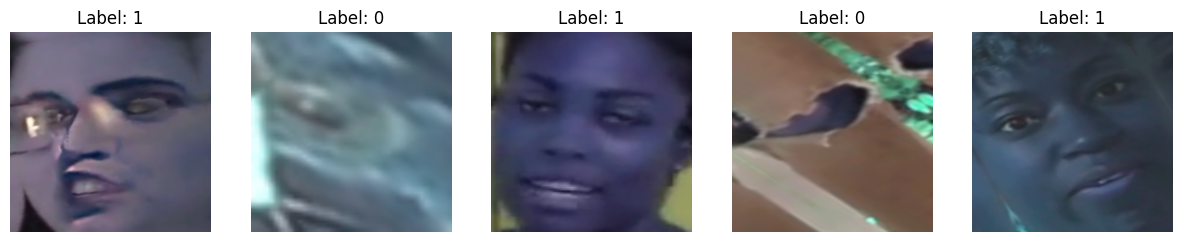

In [12]:
import matplotlib.pyplot as plt

# 하나의 배치 가져오기
def show_batch_images_and_labels(loader, num_images=5):
    # 첫 번째 배치에서 이미지와 레이블 가져오기
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # 이미지 몇 개를 시각화하기
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        img = images[i].permute(1, 2, 0).numpy()  # Tensor에서 numpy 배열로 변환 (C x H x W -> H x W x C)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Label: {labels[i].item()}")

    # 라벨 값 출력
    print("배치 라벨 값:", labels[:num_images].tolist())

    plt.show()

# 훈련 데이터의 첫 번째 배치 이미지와 라벨 값 시각화
show_batch_images_and_labels(train_loader, num_images=5)


In [13]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [23]:
import torch
import torch.nn as nn
import timm

# EfficientNet-B0 모델 (num_classes=1로 설정)
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.3):
        super(EfficientNetB0, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)  # num_classes=1로 설정
        in_features = self.model.get_classifier().in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(in_features, num_classes)  # 출력 크기 1로 설정
        )

    def forward(self, x):
        return self.model(x)

# ConvNeXt Tiny 모델 (num_classes=1로 설정)
class ConvNeXtTiny(nn.Module):
    def __init__(self, num_classes=1, dropout_prob=0.3):
        super(ConvNeXtTiny, self).__init__()
        self.model = timm.create_model('convnext_tiny', pretrained=True, num_classes=num_classes)  # num_classes=1로 설정
        in_features = self.model.get_classifier().in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(dropout_prob),
            nn.Linear(in_features, num_classes)  # 출력 크기 1로 설정
        )

    def forward(self, x):
        return self.model(x)

# 앙상블 모델
class EnsembleModel(nn.Module):
    def __init__(self, model1, model2):
        super(EnsembleModel, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        output1 = self.model1(x)
        output2 = self.model2(x)
        output = (output1 + output2) / 2  # 평균 앙상블
        return torch.sigmoid(output)  # Sigmoid 활성화

# 모델 인스턴스 생성
effnet_model = EfficientNetB0(num_classes=1, dropout_prob=0.3)
convnext_model = ConvNeXtTiny(num_classes=1, dropout_prob=0.3)
ensemble_model = EnsembleModel(effnet_model, convnext_model)

# 모델 요약 출력
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ensemble_model = ensemble_model.to(device)

print("\nEnsemble Model Summary:")
summary(ensemble_model, input_size=(3, 224, 224), device=device.type)



Ensemble Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
          Identity-2         [-1, 32, 112, 112]               0
              SiLU-3         [-1, 32, 112, 112]               0
    BatchNormAct2d-4         [-1, 32, 112, 112]              64
            Conv2d-5         [-1, 32, 112, 112]             288
          Identity-6         [-1, 32, 112, 112]               0
              SiLU-7         [-1, 32, 112, 112]               0
    BatchNormAct2d-8         [-1, 32, 112, 112]              64
          Identity-9         [-1, 32, 112, 112]               0
           Conv2d-10              [-1, 8, 1, 1]             264
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          Sigmoid-13             [-1, 32, 1, 1]               0
    SqueezeExc

In [24]:
import torch.nn as nn
import torch.optim as optim

# 모델 정의 (예: 앙상블 모델 사용)
model = ensemble_model  # 이미 정의된 ensemble_model을 사용

# BCEWithLogitsLoss를 사용
criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss로 변경

# 옵티마이저 설정: Adam + L2 정규화
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # L2 정규화 추가

# 손실 함수와 옵티마이저 확인
print("Loss Function:", criterion)
print("Optimizer:", optimizer)


Loss Function: BCEWithLogitsLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 1e-05
)


In [25]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt

def train_one_epoch(model, dataloader, criterion, optimizer, device, log_interval=100):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # 정규화 해제용 mean, std
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1).float()

        # 첫 번째 배치 시각화
        if i == 0:
            for k in range(min(5, inputs.size(0))):
                img = (inputs[k] * std + mean).clamp(0, 1)  # 정규화 해제 후 클램핑
                plt.imshow(img.permute(1, 2, 0).cpu().numpy())
                plt.show()

        optimizer.zero_grad()
        outputs = model(inputs)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()
        optimizer.step()

        # 이진화 및 정확도 계산
        preds = (torch.sigmoid(outputs) >= 0.5).float()  # Sigmoid 후 이진화
        running_loss += loss.item() * inputs.size(0)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    return running_loss / len(dataloader.dataset), 100.0 * correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 이진화
            preds = (torch.sigmoid(outputs) >= 0.5).float()  # Sigmoid 후 이진화
            running_loss += loss.item() * inputs.size(0)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / len(dataloader.dataset), 100 * correct / total


In [ ]:
import copy
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def train_one_epoch(model, dataloader, criterion, optimizer, device, log_interval=100):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        # 데이터도 GPU로 이동
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.unsqueeze(1).float()  # 이진 분류이므로 labels의 형태를 (batch_size, 1)로 맞춤

        optimizer.zero_grad()

        # 모델에 입력 전달
        outputs = model(inputs)

        # BCEWithLogitsLoss 계산
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()
        optimizer.step()

        # 손실 및 정확도 계산
        running_loss += loss.item() * inputs.size(0)
        preds_prob = torch.sigmoid(outputs)  # 시그모이드 적용하여 확률로 변환
        preds = (preds_prob >= 0.5).float()  # 예측값을 0 또는 1로 변환
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # 로그 간격마다 출력
        if (batch_idx + 1) % log_interval == 0:
            print(f'Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy


# 학습 및 테스트 설정
num_epochs = 20
best_model_wts = copy.deepcopy(ensemble_model.state_dict())  # 초기 모델 가중치 저장
best_acc = 0.0  # 최적 정확도 기준 설정

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train 데이터셋 학습
    train_loss, train_acc = train_one_epoch(ensemble_model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # 최적 모델 가중치 업데이트 (정확도가 이전보다 향상되었을 때)
    if train_acc > best_acc:
        best_acc = train_acc
        best_model_wts = copy.deepcopy(ensemble_model.state_dict())  # 최적 가중치 저장

# 최적 모델 로드
ensemble_model.load_state_dict(best_model_wts)

# 테스트 함수 정의
def test_model(model, dataloader, device):
    model.eval()  # 모델을 평가 모드로 설정
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # 데이터 GPU로 이동
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) >= 0.5).float().cpu().numpy()  # 시그모이드 적용 후 예측값을 0 또는 1로 변환

            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    return true_labels, predictions

# 테스트 데이터셋 평가 (라벨 있음)
test_true_labels, test_predictions = test_model(ensemble_model, test_loader, device)

# 정확도 계산 (0 또는 1로 변환 후 백분율 계산)
test_true_labels = np.array(test_true_labels).astype(int)  # true_labels를 int로 변환
test_predictions = np.array(test_predictions).astype(int)  # predictions을 int로 변환

# 정확도 계산
test_acc = np.mean(test_true_labels == test_predictions) * 100  # 비교 후 백분율로 변환
print(f"Test Accuracy: {test_acc:.4f}%")


Epoch 1/20
Batch [100/129], Loss: 0.4824
Train Loss: 0.6099, Train Acc: 65.7933
Epoch 2/20
Batch [100/129], Loss: 0.4298
Train Loss: 0.5229, Train Acc: 65.7933
Epoch 3/20
Batch [100/129], Loss: 0.5338
Train Loss: 0.4984, Train Acc: 65.7933
Epoch 4/20
Batch [100/129], Loss: 0.4595
Train Loss: 0.4832, Train Acc: 65.7933
Epoch 5/20
Batch [100/129], Loss: 0.4365
Train Loss: 0.4774, Train Acc: 65.7933
Epoch 6/20
